In [26]:
##TODO -> try LLM models (chat gpt or bert), 
# would be good to use both title and body

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import requests
from tqdm import tqdm
import xgboost as xgb
tqdm.pandas()
import os
from openai import OpenAI
import os

In [111]:
df_merged = pd.read_csv("../data/merged_datasetes_balanced.csv")

In [112]:
# Actually there is no need to split it here, only to stay consistent with other notebooks
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

In [113]:
file_path = r"C:\Users\Mateusz\Desktop\api_key_chat_gpt_kubita.txt" 

with open(file_path, 'r') as file:
    api_key = file.read()

# Direct prompt 

In [114]:
prompt = """You are an assistant tasked with classifying article titles as either clickbait or legitimate. Your response should be precise and straightforward: respond with only "1" if the news title appears to be clickbait, and only "0" if it seems legitimate. Do not include any additional text, explanations, or reasoning in your response.

Here are some examples:

Title: "You Won't Believe What Happened When This Dog Went to the Park!"
Response: 1

Title: "Scientists Discover New Species in the Amazon Rainforest"
Response: 0

Title: "10 Life Hacks That Will Change the Way You Live Forever"
Response: 1

Title: "Government Announces New Infrastructure Plan for 2024"
Response: 0

Title: "The Shocking Truth Behind Your Morning Coffee!"
Response: 1

Title: "Local School Wins National Award for Academic Excellence"
Response: 0
Here is the title that you need to classify: 
"""


In [115]:
prompts_test = [str(prompt + title) for title in x_test.tolist()]

In [117]:
dictionary = [{
    "custom_id": f"request{i}", 
    "method": "POST", 
    "url": "/v1/chat/completions", 
    "body": {"model": "gpt-4o-mini", 
             "messages": [
                 {"role": "system", "content": "assistant."},
                 {"role": "user", "content": prompt}],
             "max_tokens": 1000}
} for i, prompt in enumerate(prompts_test)]

In [118]:
with open("sample.jsonl", "w") as outfile:
    for request__ in dictionary:
        json.dump(request__, outfile)
        outfile.write('\n')

In [119]:
with open("sample.jsonl", 'r') as json_file:
    first_line = json_file.readline()

print(first_line)

{"custom_id": "request0", "method": "POST", "url": "/v1/chat/completions", "body": {"model": "gpt-4o-mini", "messages": [{"role": "system", "content": "assistant."}, {"role": "user", "content": "You are an assistant tasked with classifying article titles as either clickbait or legitimate. Your response should be precise and straightforward: respond with only \"1\" if the news title appears to be clickbait, and only \"0\" if it seems legitimate. Do not include any additional text, explanations, or reasoning in your response.\n\nHere are some examples:\n\nTitle: \"You Won't Believe What Happened When This Dog Went to the Park!\"\nResponse: 1\n\nTitle: \"Scientists Discover New Species in the Amazon Rainforest\"\nResponse: 0\n\nTitle: \"10 Life Hacks That Will Change the Way You Live Forever\"\nResponse: 1\n\nTitle: \"Government Announces New Infrastructure Plan for 2024\"\nResponse: 0\n\nTitle: \"The Shocking Truth Behind Your Morning Coffee!\"\nResponse: 1\n\nTitle: \"Local School Wins 

In [121]:
client = OpenAI(
    api_key=api_key,
)

batch_input_file = client.files.create(
  file=open(r"sample.jsonl", "rb"),
  purpose="batch"
)

In [122]:
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "full data"
    }
)

Batch(id='batch_6726899043b88190baeed1e4a1b0b381', completion_window='24h', created_at=1730578832, endpoint='/v1/chat/completions', input_file_id='file-yXPXujcuML6NETEO3R5fkMmP', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1730665232, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'full data'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [148]:
client.batches.retrieve("batch_6726899043b88190baeed1e4a1b0b381")

Batch(id='batch_6726899043b88190baeed1e4a1b0b381', completion_window='24h', created_at=1730578832, endpoint='/v1/chat/completions', input_file_id='file-yXPXujcuML6NETEO3R5fkMmP', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1730580429, error_file_id=None, errors=None, expired_at=None, expires_at=1730665232, failed_at=None, finalizing_at=1730580011, in_progress_at=1730578833, metadata={'description': 'full data'}, output_file_id='file-XPuAcYx9IdGDslC2LnnEE66J', request_counts=BatchRequestCounts(completed=4000, failed=0, total=4000))

In [149]:
file_response = client.files.content("file-XPuAcYx9IdGDslC2LnnEE66J")
print(file_response.text)

res = []
for line in file_response.text.splitlines():
    res.append(json.loads(line))

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [150]:
pred = []
for i in range(len(res)):
    if(res[i]['response']['body']['choices'][0]['message']['content'] not in  ["0", "1"]):
        print('lul')
    else:
        pred.append(int(res[i]['response']['body']['choices'][0]['message']['content']))

In [152]:
len(res)

4000

In [153]:
len(pred)

4000

In [151]:
res[0]['response']['body']['choices'][0]['message']['content']

'1'

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2019
           1       0.81      0.81      0.81      1981

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000



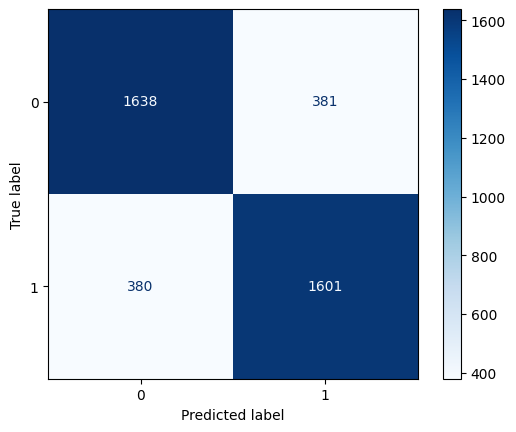

In [157]:
print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Embeddings

In [ ]:
#  You can do the same with embeddings -> get using batch file

In [137]:
x_test

10650    The Dude Who Followed His Girlfriend Around Th...
2041       UN condemns Israel's West Bank settlement plans
8668                    France to Pay Nuclear Test Victims
1114     Hong Kong Mall Escalator Snaps Into Reverse, P...
13902    23 Historic Pictures From The Macy's Thanksgiv...
                               ...                        
4073                      Mugabe Rival Is Back in Zimbabwe
7442           Texas Instruments Narrows Range of Forecast
9999     CBI cuts UK growth forecasts while warning of ...
1870     Johnny Depp's money worries blamed on $2m-a-mo...
15196    18 Posts That Prove Coconut Oil Is The Answer ...
Name: title, Length: 4000, dtype: object

In [139]:
dictionary_req = [{
    "custom_id": f"request{i}", 
    "method": "POST", 
    "url": "/v1/embeddings", 
    "body": {"model": "text-embedding-3-large",
             "input": f"{prompt}"
            }
} for i, prompt in enumerate(x_test.tolist())]

In [140]:
with open("embeddings_request.jsonl", "w") as outfile:
    for request__ in dictionary_req:
        json.dump(request__, outfile)
        outfile.write('\n')

In [141]:
with open("embeddings_request.jsonl", 'r') as json_file:
    first_line = json_file.readline()

print(first_line)

{"custom_id": "request0", "method": "POST", "url": "/v1/embeddings", "body": {"model": "text-embedding-3-large", "input": "The Dude Who Followed His Girlfriend Around The World Just Photographed Their Wedding Perfectly"}}



In [142]:
batch_input_file = client.files.create(
  file=open(r"embeddings_request.jsonl", "rb"),
  purpose="batch"
)

In [143]:
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/embeddings",
    completion_window="24h",
    metadata={
      "description": "full data embeddings test"
    }
)

Batch(id='batch_67268f6593348190a5c48e3dc7855970', completion_window='24h', created_at=1730580325, endpoint='/v1/embeddings', input_file_id='file-bNkL7jprlNscyc9gdtry8eZv', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1730666725, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'full data embeddings test'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [146]:
client.batches.retrieve("batch_67268f6593348190a5c48e3dc7855970")

Batch(id='batch_67268f6593348190a5c48e3dc7855970', completion_window='24h', created_at=1730580325, endpoint='/v1/embeddings', input_file_id='file-bNkL7jprlNscyc9gdtry8eZv', object='batch', status='in_progress', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1730666725, failed_at=None, finalizing_at=None, in_progress_at=1730580326, metadata={'description': 'full data embeddings test'}, output_file_id=None, request_counts=BatchRequestCounts(completed=116, failed=0, total=4000))

In [ ]:
def return_embeddings_chat(prompt):
    res = requests.post(f"https://api.openai.com/v1/embeddings",
        headers = {
          "Content-Type": "application/json",
          "Authorization": f"Bearer {api_key}"
        },
        json={
          "model": "text-embedding-3-large",
          "encoding_format": "float",
          "input": f"{prompt}"
        }).json()
    return res["data"][0]["embedding"]

In [25]:
def batch_embeddings(prompts, batch_size=250):
    url = "https://api.openai.com/v1/embeddings"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    embeddings = []
    for i in tqdm(range(0, len(prompts), batch_size), desc="Processing Batches"):
        batch = prompts[i:i + batch_size]
        response = requests.post(url, headers=headers, json={
            "model": "text-embedding-3-large",
            "encoding_format": "float",
            "input": batch
        }).json()
        embeddings.extend([item["embedding"] for item in response["data"]])
    return embeddings

embeddings_train = batch_embeddings(x_train.tolist())
embeddings_x_train_df = pd.DataFrame(embeddings_train)

embeddings_test = batch_embeddings(x_test.tolist())
embeddings_x_test_df = pd.DataFrame(embeddings_test)

Processing Batches: 100%|██████████████████████████████████████████████████████████████| 16/16 [01:20<00:00,  5.02s/it]


In [31]:
embeddings_x_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.007708,0.002197,-0.014086,0.014623,-0.008665,-0.006117,-0.017423,0.028887,-0.000700,-0.000989,...,-0.018060,0.030225,-0.023598,0.024703,-0.006082,-0.007187,-0.008532,0.000581,-0.013207,0.010376
1,0.003838,0.015038,-0.017042,-0.000516,0.022288,-0.011407,0.011695,0.003888,-0.007381,0.019684,...,-0.009091,-0.005672,-0.007169,0.000538,0.011958,-0.000009,0.004267,0.003584,-0.012947,-0.004527
2,0.008249,-0.034727,-0.002449,-0.062764,-0.028221,0.033678,0.013288,0.001389,0.012948,-0.011091,...,0.014713,-0.006832,0.006414,0.001363,-0.014670,0.001666,0.013253,-0.007307,-0.020680,0.011970
3,0.016529,-0.026904,-0.019269,-0.006891,0.016948,-0.033656,0.030542,0.021529,-0.005573,0.034555,...,-0.016274,0.008182,-0.003741,-0.008175,0.026590,-0.010345,0.014987,0.012060,0.010600,-0.019673
4,0.008426,-0.036027,-0.021843,-0.001583,-0.021856,-0.024984,-0.000015,0.022546,-0.040112,0.033806,...,-0.018971,0.012045,0.025852,-0.006297,-0.017452,0.000578,0.012518,-0.000217,-0.018116,0.007788


# Model fitting with embeddings

0.844
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2019
           1       0.88      0.80      0.84      1981

    accuracy                           0.84      4000
   macro avg       0.85      0.84      0.84      4000
weighted avg       0.85      0.84      0.84      4000



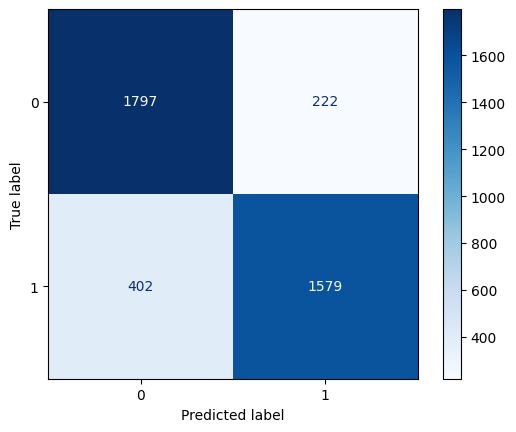

In [29]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(embeddings_x_train_df, y_train)

pred_rf = RF.predict(embeddings_x_test_df)
print(RF.score(embeddings_x_test_df, y_test))
print(classification_report(y_test, pred_rf))

cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2019
           1       0.87      0.82      0.84      1981

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



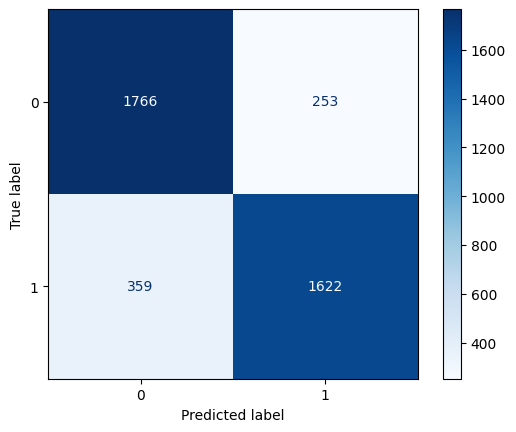

In [30]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(embeddings_x_train_df, y_train)

pred_xgb = xgb_model.predict(embeddings_x_test_df)

cm = confusion_matrix(y_test, pred_xgb)
print(classification_report(y_test, pred_xgb))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()